# [Study the DeepSea Winning Strategy](http://benanne.github.io/2015/03/17/plankton.html)


I'm Kent Chiu. 

If my articles do help you, please consider for sharing my blog on your twitter/facebook/Instagram. Also, please consider for donation if within your reach, it would be a greate support to me for continuing this journey. Thank you : ) 

### 0. Overviews
- Introduction
- Objectives
- Pre-process & Data Augmentation
- Network architecture (Cycling Pool)
- Training
- [Model Average](http://arxiv.org/abs/1503.02531) One of the most powerful way
- Unsupervised and semi-supervised approaches
- Miscellany
- Reference Links



### 1. Introduction 

- This article is to study the winning strategy from DeepSea team in Kaggle competition. You could click the Title of this post, it would directly lead you to the orinal post.


### 2. Objectives
- Learning some key strategies from the original post such as 
 - data augmentation
 - cycling pool
 - unsupervised pre-training as an regularization 
 - model average
 - 

### 3. Pre-process and Data augmentation

##### 3-1. Zero Components Analysis 
- [ZCA whitening transformation : See Appendix A](http://www.cs.toronto.edu/~kriz/learning-features-2009-TR.pdf)
 - Zero Components Analysis (ZCA) is a better way to Principle Components Analysis (PCA) to let the model to focus on high order correlations learning rather than 2-way correlations learning.
 
 - A whitening transformation is a linear transformation that transforms a vector of random variables with a known covariance matrix into a set of new variables whose covariance is the identity matrix meaning that they are uncorrelated and all have variance 1.[1] The transformation is called "whitening" because it changes the input vector into a white noise vector.
 
 - W is called a whitening matrix, and is referred to as the ZCA solution. W may also be thought of as rotating X to the space of its principal components, dividing each procipal component by the square root of the variance in that direction and then rotation back to pixel space.

##### 3-2. Colour perturbation
 - After this, the colour of the images was changed as described in [Krizhevsky et al. 2012](http://www.cs.toronto.edu/~fritz/absps/imagenet.pdf), with two differences: the first component had a much larger eigenvalue than the other two, so only this one was used, and the standard deviation for the scale factor alpha was set to 0.5

##### 3-3. Realtime” augmentation

 - Combining downsampling and perturbation into a single affine transform made it possible to do data augmentation in realtime, i.e. during training. This significantly reduced overfitting because the network would never see the exact same image twice. While the network was being trained on a chunk of data on the GPU, the next chunk would be generated on the CPU in multiple processes, to ensure that all the available cores were used.

- Centering and rescaling

 - I experimented with centering and rescaling the galaxy images based on parameters extracted with sextractor. Although this didn’t improve performance, including a few models that used it in the final ensemble helped to increase variance (see “Model averaging” for more information).

 - I extracted the center of the galaxies, as well as the Petrosian radius. A number of different radii can be extracted, but the Petrosian radius seemed to give the best size estimate. I then centered each image by shifting the estimated center pixel to (212, 212), and rescaled it so that its Petrosian radius would be equal to 160 pixels. The scale factor was limited to the range (1/1.5, 1.5), because there were some outliers.

 - This rescaling and centering could also be collapsed into the affine transform doing downsampling and perturbation, so it did not slow things down at all.

##### 3.4 cPic
- H5py library is used to store extremely large NumPy arrays on disk -- arrays so large that they would not fit into your main memory. Since they won't fit into your RAM, you can't use cPickle to save and load them. Instead, you use h5py to access and manipulate these arrays that would be otherwise to large to load.

- When it comes to extracting features from a dataset of images, our resulting database could be many gigabytes, hundreds of gigabytes, or even terabytes of data. This dataset is too large to store in main memory, so instead, we use HDF5.


##### Python Package for data augmentation
- [Keras.preprocessing.image.ImageDataGenerator()](https://keras.io/preprocessing/image/)
- [Introduction for Keras Image Augmentation](http://machinelearningmastery.com/image-augmentation-deep-learning-keras/)
- [skimage](http://scikit-image.org/docs/dev/api/skimage.transform.html)

Using Theano backend.
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.


['C:\\Users\\Davis/.theanorc', 'C:\\Users\\Davis/.theanorc.txt']


WARNING (theano.sandbox.cuda): CUDA is installed, but device gpu is not available  (error: cuda unavailable)


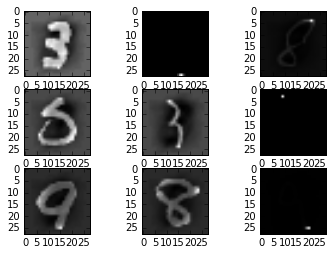

In [1]:

# Standardize images across the dataset, mean=0, stdev=1
from keras.datasets import mnist
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot
%matplotlib inline

# load data
(X_train, y_train), (X_test, y_test) = mnist.load_data()
# reshape to be [samples][pixels][width][height]
X_train = X_train.reshape(X_train.shape[0], 1, 28, 28)
X_test = X_test.reshape(X_test.shape[0], 1, 28, 28)
# convert from int to float
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
# define data preparation
datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)
# fit parameters from data
datagen.fit(X_train[:100])
# configure batch size and retrieve one batch of images
for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=9):
	# create a grid of 3x3 images
	for i in range(0, 9):
		pyplot.subplot(330 + 1 + i)
		pyplot.imshow(X_batch[i].reshape(28, 28), cmap=pyplot.get_cmap('gray'))
	# show the plot
	pyplot.show()
	break

### 4. Network Archetecture 

##### 4-1. Generally Concept

- It might be little tricky but you have to overfit first then start to find the method to avoid overfitting. Generally, try to use large nn 

- The reason is, if you’re not overfitting, your network isn’t big enough. If your network is not big enough, it is not possible for your model to have enough space to tell and classify your data. 

- Gradient Check 

##### 4-2. General way to avoid overfitting 
- data augmentation
- dropout and weight norm constraints
- modifying the network architecture to increase parameter sharing


##### 4-3 One by one convolution Strategy
- 
- This [Link](https://github.com/vdumoulin/conv_arithmetic) Shows the Visualization of the different CNN architecture for the variables range from Stride, Pool, Paddle.
- This [Link](http://iamaaditya.github.io/2016/03/one-by-one-convolution) Explaned that why one-by-one convolution strategy works

##### 4-4 Well Design your loss function, add bias terms if a biased source dataset
- inverse F1 score, this implementation would cause a small loss function with upper bound
- http://stackoverflow.com/questions/35013822/log-loss-output-is-greater-than-1
- If the output is a tensor => further design your loss function 

### 5. Training 

##### 5.1 Momentum Method vs Simple Gradient Descent vs Stochastic Gradient Descent 
- [Extremly Amazing Articles](http://sebastianruder.com/optimizing-gradient-descent/index.html#momentum)

$e^{i\pi} + 1 = 0$

$ \int (x+y)dx $

##### 5.2 Nesterov momentum 
- Check this nice [Link](http://stats.stackexchange.com/questions/179915/whats-the-difference-between-momentum-based-gradient-descent-and-nesterovs-ac)
- Check this [Video by Geoffrey Hinton](https://www.youtube.com/watch?v=8yg2mRJx-z4) 
- Nesterov method takes the gamble to correction approach. 

##### 5.3 Batch size effect 
- Hi Maineiac - Also, the first time using NNs. Here are some posts that I found helpful. Generally, the smaller the batch size the noisier the updates (like emolson said), so if you decrease the batch size you should probably decrease the learning rate, and train for more iterations.

- I found the two links below helpful. One is blog post from Ilya Sutskever, which has some practical advice at the bottom. Also, see the caffe thread. They talk a bit about how to adjust the learning rate for smaller batch sizes. 

- The best minibatch size will depend on the data and network, and as far as I know there's no real "rule of thumb" for choosing it. I would find a value that works efficiently with your hardware and then try a few adjustments

- http://yyue.blogspot.com/2015/01/a-brief-overview-of-deep-learning.html

- https://github.com/BVLC/caffe/issues/430

##### 5.4 Training a large dataset that cant not fit into memory

- use random sampling => make sure your mini-batch data and weight can be loaded into the CPU-Memory and GPU-memory 

```python 
import numpy as np

select_key_path = np.random.randint(0, len(dataset)

```

- https://github.com/fchollet/keras/issues/2708

##### 5.5 Pre-trained weight + freezing layer + pop + add model 
- use pop and add in keras 

##### 5.6 

### Reference Links
- [Build Autoencoder in Keras](https://blog.keras.io/building-autoencoders-in-keras.html)
- [Why does unsupervised pretraining help deep learning ?](http://www.jmlr.org/papers/volume11/erhan10a/erhan10a.pdf)
- [DeepSee_Member_ Ira Korshunova_Blog](http://irakorshunova.github.io/2016/03/15/heart.html)
- [Data Augmentation: Galaxy-zoo winning strategy](http://benanne.github.io/2014/04/05/galaxy-zoo.html)

$$c = \sqrt{a^2 + b^2}$$

In [1]:
from IPython.core.display import HTML
HTML("""<style>
div.text_cell_render h1 {font-size: 2.4em;line-height:2.4em;text-align:left;}
div.text_cell_render h3 {font-size: 1.8em;line-height:1.8em;text-align:left;}
div.text_cell_render p {font-size: 1.4em;line-height:1.4em;text-align:left;}
div.text_cell_render li {font-size: 1.0em;line-height:1.0em;text-align:left;}
div.container pre{font-family: Monaco;font-size: 1.2em;line-height:1.2em;}
</style>""")